# HMS - Harmful Brain Activity Classification

## Цель
Попрактиковаться извлекать признаки с помощью классических методов собственными руками, а также с помощью AutoML методов.

## Задачи
- Попробовать извлечь признаки с помощью преобразования Фурье
- Попробовать извлечь признаки с помощью вейвлет анализа
- Попробовать извлечь признаки с помощью плотности спектральной мощности
- Попробовать извлечь признаки с помощью AutoML


## Замечания
В рамках данной задачи, это не является лучшим решением, так как извлечение признаков для этих данных очень дорогостоящий процесс, и такую задачу можно решить более просто, с помощью компьютерного зрения. Поэтому мы просто извлечем первые 5 точек данных, чтобы наглядно показать, какие признаки мы можем получить с помощью классических методов собственными руками, а также с помощью AutoML методов.

In [1]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
from collections import Counter

from scipy.fftpack import fft
from scipy.signal import welch, find_peaks
from scipy.stats import entropy

from sklearn.feature_selection import VarianceThreshold

import pywt
import tsfel

## Load data

In [3]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')

In [4]:
train = train.iloc[:5,:]

In [5]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## Furior, wavelet, psd features

In [6]:
# Train eegs
Fs_eeg = 200 # Частота дискретизации
T_eeg = 1/Fs_eeg # Период
N_eeg = 12000 # Число отсчётов

# Train spectrograms
Fs_spt = 0.5 # Частота дискретизации
T_spt = 2 # Период
N_spt = 600 # Число отсчётов

In [7]:
def get_fft_features(data: pd.DataFrame, Fs: int, N:int) -> tuple:
    """
    Compute the Fourier Transform (FFT) features
        
    Parametrs:  
    data (pd.DataFrame): Input data with shape (n_timeseries, n_features).  
    Fs (int): Sampling frequency of the input daata.  
    N (int): Number of points in the FFT.  
        
    Return:  
    tuple: A tuple containing two elements:
           - f_values (np.ndarray): Array of frequency values.
           - fft_values (np.ndarray): Array of FFT magnitudes.
    """
    # Частота Найквиста Fs/2 - максимальная частота, которую можно правильно обнаружить и восстановить при дискретизации сигнала
    f_values = np.linspace(0.0, Fs/2, N//2)
    
    fft_values = fft(data)
    fft_values = 2.0/N * np.abs(fft_values[:,:N//2])
    
    return (f_values, fft_values)

def get_psd_features(data: pd.DataFrame, Fs: int) -> tuple:
    """
    Compute the Power Spectral Density (PSD) features
        
    Parametrs:  
    data (pd.DataFrame): Input data with shape (n_timeseries, n_features).  
    Fs (int): Sampling frequency of the input data.  
      
    Return:  
    np.ndarray: The psd (Power Spectral Density) features.
    """
    features_dict = {} 
    f_psd_values, psd_values = welch(data, fs=Fs)
    for i in range(len(psd_values)): 
        peaks, _ = find_peaks(psd_values[i], height=10)

        if len(psd_values[i][peaks]) <= 3:
            features_dict[f'{data.index[i]}_psd'] = np.sum(psd_values[i][peaks])
        else:
            ind_part = np.argpartition(psd_values[i][peaks], -3)[-3:]
            top_psd_values = np.take_along_axis(psd_values[i][peaks], ind_part, axis=-1)
            features_dict[f'{data.index[i]}_psd'] = np.sum(top_psd_values)
            
    features_df = pd.DataFrame([features_dict])
    return (f_psd_values, psd_values, features_df)

def get_wavelet_features(data: pd.DataFrame) -> list:
    """
    Compute the wavelet features
        
    Parametrs:  
    data (pd.DataFrame): Input data with shape (n_features, n_timeseries).
      
    Return:  
    np.ndarray: The wavelet features.
    """
    features_dict = {} 

    for col in data.columns:
        feature_wavelet = []

        coeffs = pywt.wavedec(data[col],'rbio3.1')
        
        for i,coeff in enumerate(coeffs):       
            cnt_vals = Counter(coeff).most_common()
            features_dict[f'{col}{i}_entropy'] = entropy([el[1]/len(cnt_vals) for el in cnt_vals])
            features_dict[f'{col}{i}_mean'] = np.nanmean(coeff)
            features_dict[f'{col}{i}_std'] = np.nanstd(coeff)
            features_dict[f'{col}{i}_rms'] = np.sqrt(np.nanmean(coeff**2))
            features_dict[f'{col}{i}_median'] = np.nanmedian(coeff)
            
    features_df = pd.DataFrame([features_dict])
    return features_df

<h2>AutoML</h2>

Регистрирующие области электродов ЭЭГ:  
- LL - левая латеральная
- RL - правая латеральная
- LP - левая парасагиттальная
- RP - правая парасагиттальная  
  
Мы имеем 400 временных рядов для этих 4 групп на разных частотах, мы объединим в эти группы, а далее для каждой из них найдем средние значения.

In [8]:
LL_arr = []
RL_arr = []
LP_arr = []
RP_arr = []

for col in pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000086677.parquet'):
    if 'LL' in col:
        LL_arr.append(col)
    if 'RL' in col:
        RL_arr.append(col)
    if 'LP' in col:
        LP_arr.append(col)
    if 'RP' in col:
        RP_arr.append(col)

Будем использовать библиотеку tsfel, с помощью которой мы сможем автоматически извлечь признаки из временных рядов

In [9]:
def get_automl_features(data: pd.DataFrame, Fs: float) -> pd.DataFrame:
    """
    Extracts temporal features from the input data using TSFEL (Time Series Feature Extraction Library)
    and computes mean values for specified groups of features.

    Parameters:
    data (pd.DataFrame): Input data with shape (n_timeseries, n_features).
    Fs (int): Sampling frequency of the input data.

    Returns:
    pd.DataFrame: A DataFrame containing the mean values of the extracted features for each specified group.
    """
    cfg = tsfel.get_features_by_domain('temporal')
    temp_df = pd.DataFrame()
    cols_arr = data.columns
    for col in data.columns:
        temp_features = tsfel.time_series_features_extractor(cfg, data[col].values, fs=Fs, verbose=0)
        temp_df = pd.concat([temp_df, temp_features])
        
    temp_df.index = data.columns
    
    # Считаем средние значения для каждой из групп LL, RL, LP, RP
    features_dict = {}
    
    for col in temp_df.columns:
        features_dict[f'{col}_LL_mean'] = np.nanmean(temp_df.loc[LL_arr,:].values)
        features_dict[f'{col}_RL_mean'] = np.nanmean(temp_df.loc[RL_arr,:].values)
        features_dict[f'{col}_LP_mean'] = np.nanmean(temp_df.loc[LP_arr,:].values)
        features_dict[f'{col}_RP_mean'] = np.nanmean(temp_df.loc[RP_arr,:].values)
    
    
    features_df = pd.DataFrame([features_dict])
    return features_df

## Get features

Напишем функцию, с помощью которой мы сможем получить признаки как для ЭЭГ, так и для спектрограмм.

In [10]:
TRAIN_EEGS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
TRAIN_SPECTROGRAMS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'

def get_all_features(data: pd.DataFrame) -> tuple:
    """
    Extracts and combines various features from EEG data (PSD (Power Spectral Density),
    wavelet transforms) and spectrograms data (AutoML) for each row in the input DataFrame.
      
    Parameters:
    data (pd.DataFrame): Input DataFrame containing metadata for each EEG recording.

    Returns:
    tuple: A tuple containing two elements:
           - DataFrame of eeg features.
           - DataFrame of spectrogram features.
    """
    all_psd_df = pd.DataFrame()
    all_wavelet_df = pd.DataFrame()
    all_spectrogram_df = pd.DataFrame()

    for row in tqdm(data.iterrows(), total=data.shape[0]):

        eeg = pd.read_parquet(f'{TRAIN_EEGS_PATH}{row[1]["eeg_id"]}.parquet')

        # Время между двумя отсчетами равно периоду T и равно 0.005c
        # Найдем начало и конец подвыборки eeg, которая задана для каждой строки
        # Достаем признаки из eeg
        start_eeg_sub = int(row[1]['eeg_label_offset_seconds']//T_eeg)
        end_eeg_sub = int((row[1]['eeg_label_offset_seconds']+50)//T_eeg)
        start_eeg_sub = start_eeg_sub - 1 if start_eeg_sub!=0 else 0
        eeg = eeg.iloc[start_eeg_sub:end_eeg_sub,:-1]
        f_psd_values, psd_values, psd_df = get_psd_features(eeg.T, Fs_eeg)
        wavelet_df = get_wavelet_features(eeg)
        
        # Достаем признаки из spectrogram.
        spectrogram = pd.read_parquet(f'{TRAIN_SPECTROGRAMS_PATH}{row[1]["spectrogram_id"]}.parquet')
        start_spectrogram_sub = int(row[1]['spectrogram_label_offset_seconds']//T_spt)
        spectrogram = spectrogram.iloc[start_spectrogram_sub:,1:]
        spectrogram_df = get_automl_features(data=spectrogram, Fs=Fs_spt)
    
        all_spectrogram_df = pd.concat([all_spectrogram_df, spectrogram_df])
        all_psd_df = pd.concat([all_psd_df, psd_df])
        all_wavelet_df = pd.concat([all_wavelet_df, wavelet_df])
    
    return (pd.concat([all_wavelet_df, all_psd_df],axis=1), all_spectrogram_df)

Почему преобразование Фурье мы не использовали? Потому что преобразования Фурье дает малоинформативную информацию. Возьмем случайную точку данных и посмотрим на неё.

In [11]:
train.iloc[-1,:]

eeg_id                              1628180742
eeg_sub_id                                   4
eeg_label_offset_seconds                  24.0
spectrogram_id                          353733
spectrogram_sub_id                           4
spectrogram_label_offset_seconds          24.0
label_id                            3080632009
patient_id                               42516
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 4, dtype: object

In [12]:
one_sample = pd.read_parquet(f'{TRAIN_EEGS_PATH}{1628180742}.parquet')

start_eeg_sub = int(train.iloc[-1,:]['eeg_label_offset_seconds']//T_eeg)
end_eeg_sub = int((train.iloc[-1,:]['eeg_label_offset_seconds']+50)//T_eeg)
start_eeg_sub = start_eeg_sub - 1 if start_eeg_sub!=0 else 0
one_sample = one_sample.iloc[start_eeg_sub:end_eeg_sub,:-1]

f_values, fft_values = get_fft_features(data=one_sample.T, Fs=Fs_eeg, N=N_eeg)

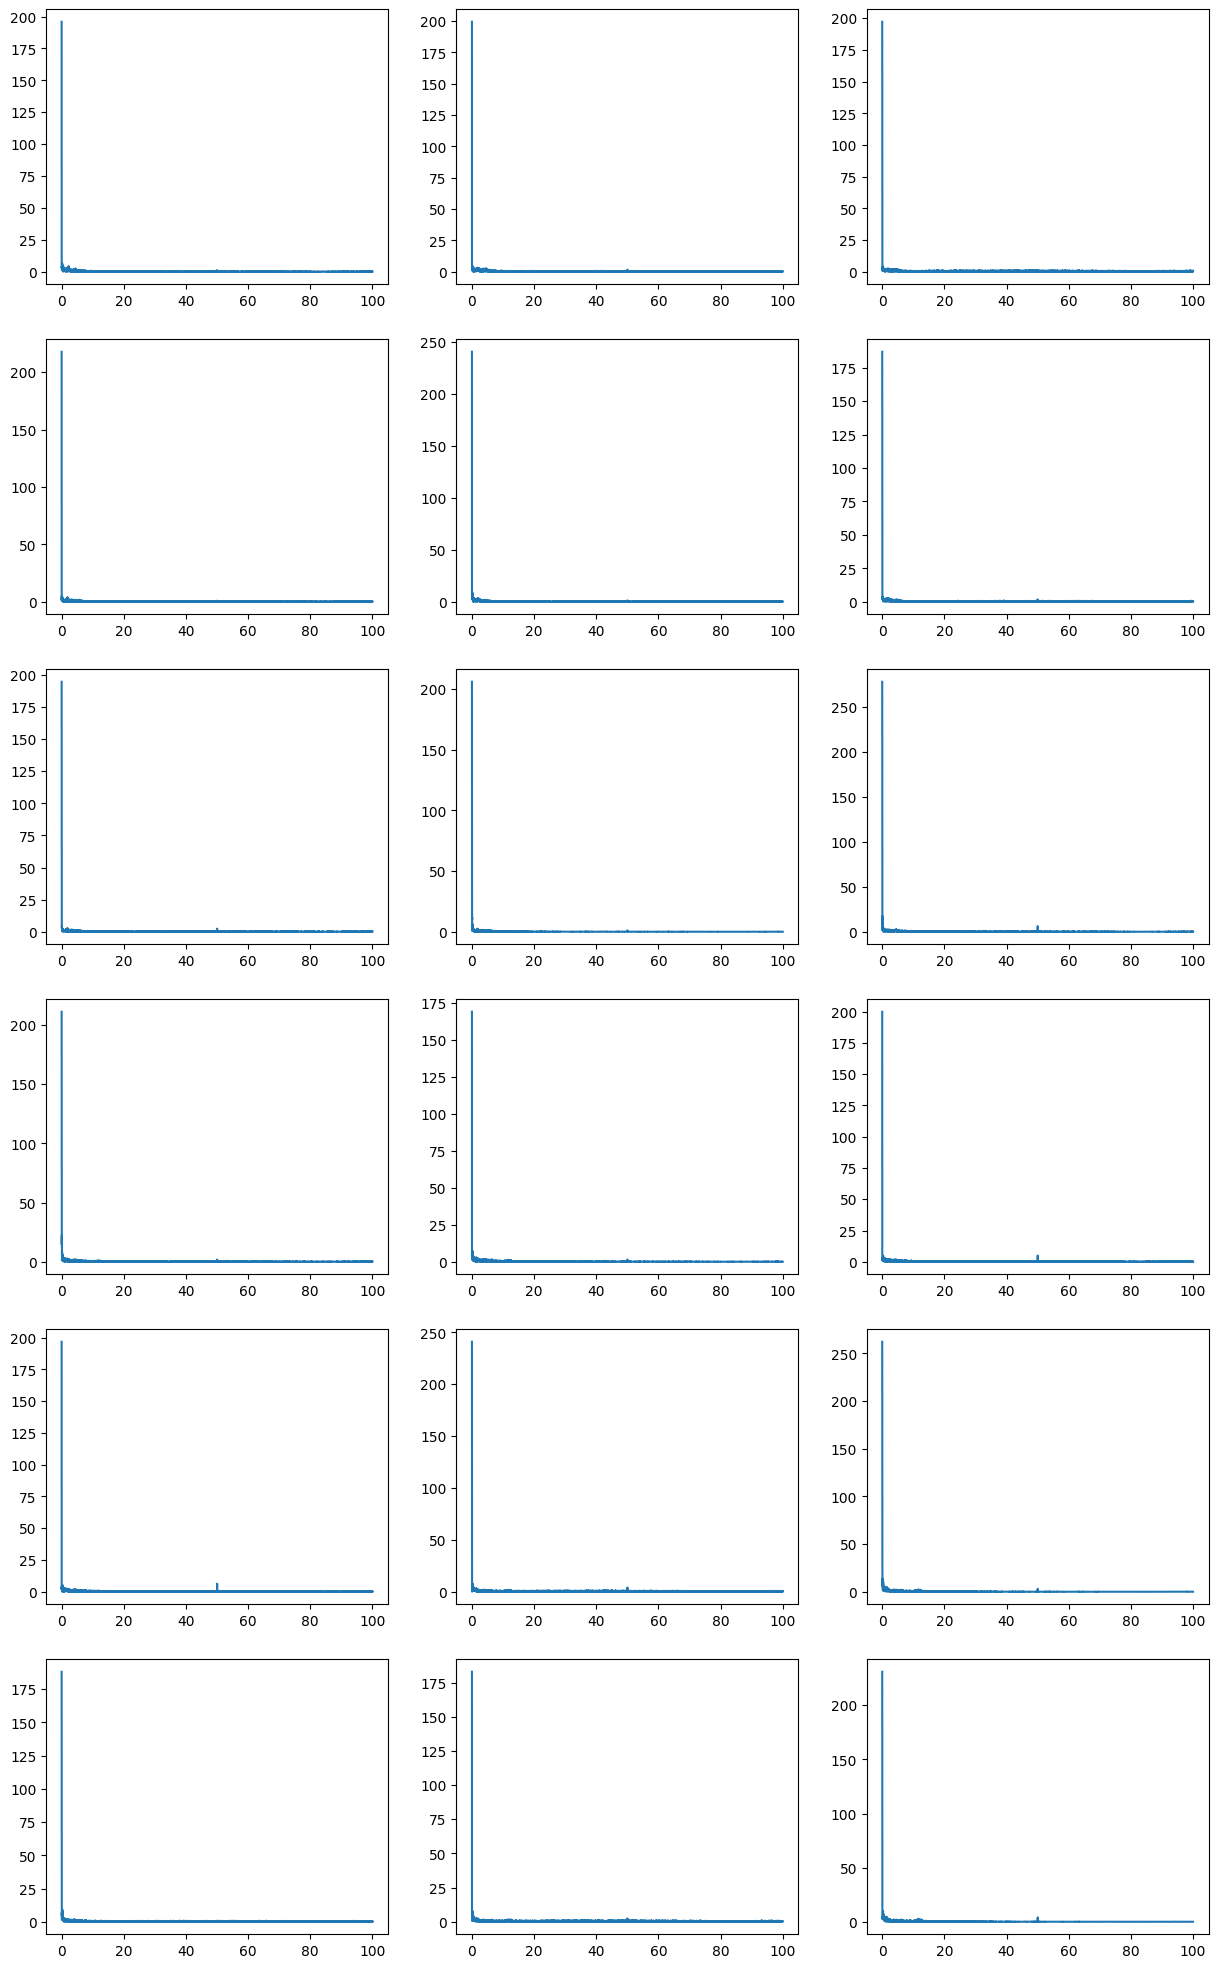

In [13]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,25))

for i, ax in enumerate(axes.ravel()):
    ax.plot(f_values, fft_values[i])

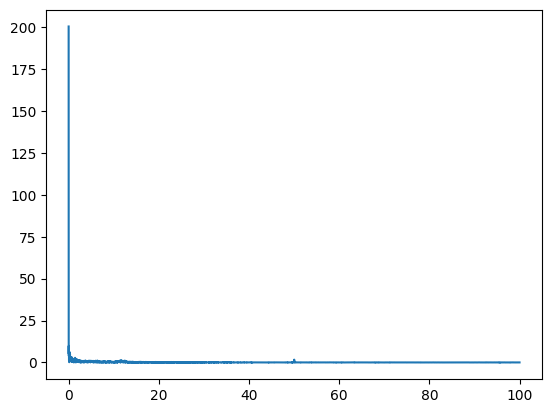

In [14]:
plt.plot(f_values, fft_values[-1])

Как видим, пиков почти нет, очень много маленьких частот, которые могут перекрываться, как мне кажется.

data_eegs:  
- `<electrode_name>_psd`: Сумма трех наиболее мощных пиков для каждого спектра мощности  
- `<electrode_name><n_wavelet>_entropy`: Энтропия одного вейвлет разложения  
- `<electrode_name><n_wavelet>_mean`: Среднее значение одного вейвлет разложения     
- `<electrode_name><n_wavelet>_std`: Стандартное отклонение одного вейвлет разложения   
- `<electrode_name><n_wavelet>_rms`: Среднеквадратичное значение одного вейвлет разложения   
- `<electrode_name><n_wavelet>_median`: Медиана одного вейвлет разложения  
1159 features
  
data_spectrograms:
- `<AutoML_feature_LL_mean>`
- `<AutoML_feature_RL_mean>`
- `<AutoML_feature_LP_mean>`
- `<AutoML_feature_RP_mean>`  
56 features

In [15]:
data_eegs, data_spectrograms = get_all_features(train)

  0%|          | 0/5 [00:00<?, ?it/s]

Уберем коррелированные признаки, а также признаки дисперсия которых равна 0.

In [16]:
def get_cleaned_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing highly correlated features and features with zero variance.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data to be cleaned.

    Returns:
    pd.DataFrame: A cleaned DataFrame with highly correlated features and features with zero variance removed.
    """
    corr_features = tsfel.correlated_features(data, threshold=0.8)
    data = data.drop(corr_features, axis=1)

    thr_var = VarianceThreshold(threshold=0)
    thr_var.fit(data)
    inds = thr_var.get_support(indices=True)
    data = data.iloc[:,inds]
    
    return data

In [17]:
data_eegs_cleaned = get_cleaned_data(data_eegs)
data_spectrograms_cleaned = get_cleaned_data(data_spectrograms)

In [18]:
data_spectrograms_cleaned

,0_Area under the curve_LL_mean
0,211.789109
0,209.772620
0,209.124715
0,205.914218
0,203.593954


In [19]:
data_eegs_cleaned

,Fp10_mean,Fp10_std,Fp11_entropy,Fp11_mean,Fp12_median,Fp13_entropy,Fp14_mean,Fp15_std,Fp16_mean
0,-5312.231934,215.138260,1.945910,-83.162300,0.000000,3.028029,-4.573252,128.102417,-2.028580
0,-5452.796875,202.371964,1.945910,-14.268799,-78.793884,3.091042,6.778633,126.660690,4.725431
0,-5088.032715,318.037903,1.945910,-17.747402,-0.000092,3.028029,-13.465321,126.133247,0.964425
0,-5137.831543,566.644287,1.945910,191.963013,13.677032,3.091042,3.269587,126.960999,0.560118
0,-5526.247070,459.487518,1.747868,-142.928482,-0.000031,3.091042,-3.181209,127.357063,-2.985119


## Результаты
Мы получили два датасета для ЕЕГ и спектрограмм соответственно. Можно заметить, что признаков стало довольно мало после очистки, значит было много коррелированных признаков и немного признаков с дисперсией 0.